In [2]:
import pymorphy2
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
morph = pymorphy2.MorphAnalyzer()

1. Подготовка и обработка данных.

In [4]:
def my_split(res, seps):
    for sep in seps:
        s, res = res, []
        for seq in s:
            res += seq.split(sep)
    return res

In [5]:
sentence_list = []

total_words = 0
total_twits = 0
count_words = {}
freq_in_twits = {}
twits_length = {}
word_estimations = {}

separators = ['.', ',', '*', '"', "'", ':', ';', '!', '?']
ignore_word_type = ['PREP', 'CONJ', 'PRCL', 'INTJ', None]

In [6]:
def parse_sentence(line):
    sentence = []
    ignore_flag = False
    for word in line:
        if ignore_flag:
            ignore_flag = False
            continue
        if word == '#':
            ignore_flag = True
            continue
        if r".com/" not in word:
            word = my_split([word], separators)
            sentence += word
        # print(word, morph.normal_forms(word)[0], morph.tag(word)[0].POS)
    sentence = [morph.normal_forms(word)[0] for word in sentence
                if word != '' and morph.tag(word)[0].POS not in ignore_word_type]
    return sentence

In [7]:
class SentenceNote:
    def __init__(self, line):
        self.estimation = 0
        line = line.split()
        day = list(map(int, line[0].split('-')))
        time = list(map(int, line[1].split(':')))
        self.time = datetime(day = day[2], month = day[1], year = day[0], hour = time[0], minute = time[1])
        raw_sentence = parse_sentence(line[2:])
        self.size = len(raw_sentence)
        self.used_words = {}
        for word in raw_sentence:
            if self.used_words.get(word, 0) == 0:
                self.used_words[word] = 0
            self.used_words[word] += 1

    def __str__(self):
        return "    ".join([str(self.time), str(self.used_words.items())])
    
    def __repr__(self):
        return self.__str__()

In [8]:
with open("data_utf8.txt", encoding='UTF8') as file:
    for line in file:
        line = line.strip()
        if len(line) == 0:
            continue
        sentence = SentenceNote(line)
        sentence_list.append(sentence)

2. Частотный анализ.

In [9]:
total_twits = len(sentence_list)

for sentence in sentence_list:
    total_words += sentence.size
    if twits_length.get(sentence.size, 0) == 0:
        twits_length[sentence.size] = 0
    twits_length[sentence.size] += 1
    
    for word, count in sentence.used_words.items():
        if count_words.get(word, 0) == 0:
            count_words[word] = 0
        count_words[word] += count
        if freq_in_twits.get(word, 0) == 0:
            freq_in_twits[word] = 0
        freq_in_twits[word] += 1

In [10]:
file = open("frequency.txt", 'w', encoding='UTF8')
for word, cnt in sorted(freq_in_twits.items(), key= lambda x: x[1], reverse = True):
    print("%s - %d - %.3f%%" % (word, freq_in_twits[word], freq_in_twits[word]/total_twits*100), file=file)
file.close()

In [11]:
file = open("twits_length.txt", 'w', encoding='UTF8')
sum_twits = 0
for length, cnt in sorted(twits_length.items(), key= lambda x: x[1], reverse = True):
    sum_twits += cnt
    print("%d - %d - %.3f%%" % (length, cnt, cnt/total_twits*100), file= file)
file.close()
sum_twits == total_twits

True

3. Эмпирическая оценка/разметка отдельных слов.

In [12]:
# file = open("word_score_no.txt", 'w', encoding='UTF8')
# for word, cnt in sorted(freq_in_twits.items(), key= lambda x: x[1], reverse = True):
#     print(word, "" if freq_in_twits[word] > 1 else 0, file=file)
# file.close() 

4. Правила классификации. Оценка твитов. Сравнительный анализ.

In [13]:
with open("estimations.txt", encoding='UTF8') as file:
    for line in file:
        line = line.strip().split()
        if(len(line) == 1) : print(line)
        word, score = line[0], int(line[1])
        word_estimations[word] = score

In [14]:
with open('classifications.txt.', 'w', encoding='UTF8') as file:
    pass

In [15]:
for sentence in sentence_list:
    for word, number in sentence.used_words.items():
        sentence.estimation += word_estimations.get(word, 0) * number

{'bad_sentences': 841, 'neutral_sentences': 7212, 'good_sentences': 1947}


<BarContainer object of 3 artists>

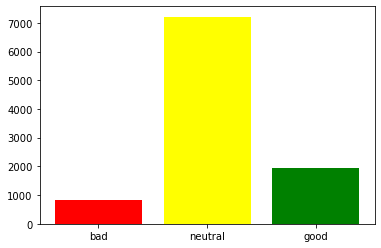

In [16]:
rule_1 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    if sentence.estimation < -1:
        rule_1['bad_sentences'] += 1
    elif sentence.estimation <= 1:
        rule_1['neutral_sentences'] += 1
    else :
        rule_1['good_sentences'] += 1
print(rule_1)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 1:', file= file)
    for classification, number in rule_1.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)

plt.bar(x=[-1,0,1], height = rule_1.values(), align ='center', color=['red', 'yellow', 'green'], 
        tick_label = ['bad', 'neutral', 'good'])

{'bad_sentences': 2298, 'neutral_sentences': 3603, 'good_sentences': 4099}


<BarContainer object of 3 artists>

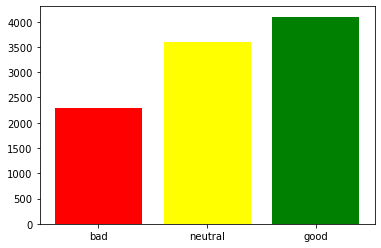

In [17]:
rule_2 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    if sentence.estimation < 0:
        rule_2['bad_sentences'] += 1
    elif sentence.estimation == 0:
        rule_2['neutral_sentences'] += 1
    else :
        rule_2['good_sentences'] += 1
print(rule_2)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 2:', file= file)
    for classification, number in rule_2.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)
plt.bar(x=[-1,0,1], height = rule_2.values(), align ='center', color=['red', 'yellow', 'green'],
        tick_label = ['bad', 'neutral', 'good'])

{'bad_sentences': 107, 'neutral_sentences': 9791, 'good_sentences': 102}


<BarContainer object of 3 artists>

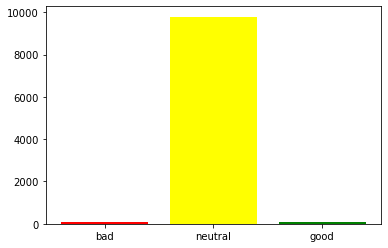

In [18]:
rule_3 = {'bad_sentences':0, 'neutral_sentences':0,'good_sentences':0}
for sentence in sentence_list:
    bad, neutral, good = 0, 0, 0
    for word, number in sentence.used_words.items():
        word_type = word_estimations.get(word, 0)
        if word_type < 0:
            bad += number
        elif word_type == 0:
            neutral += number
        else:
            good += number
    if neutral >= good and neutral >= bad or bad == good:
        rule_3['neutral_sentences'] += 1
    elif bad > good:
        rule_3['bad_sentences'] += 1
    else:
        rule_3['good_sentences'] += 1

print(rule_3)

with open('classifications.txt.', 'a+', encoding='UTF8') as file:
    print('Rule 3:', file= file)
    for classification, number in rule_3.items():
        print('%s - %d - %.3f%%' % (classification, number, 100*number/total_twits), file= file)
    print(file=file)
plt.bar(x=[-1,0,1], height = rule_3.values(), align ='center', color=['red', 'yellow', 'green'],
        tick_label = ['bad', 'neutral', 'good'])

5. Части речи. (Достроить 2 графика)

In [19]:
possitive_list = []
negative_list = []
with open('estimations.txt', encoding='UTF8') as file:
    for line in file:
        line = line.strip().split()
        word = line[0]
        word_estimation = int(line[1])
        if morph.tag(word)[0].POS == 'ADJF':
            if word_estimation == 1 and len(possitive_list) < 5:
                possitive_list.append(word)
            if word_estimation == -1 and len(negative_list) < 5:
                negative_list.append(word)
with open('adjectives.txt.', 'w', encoding='UTF8') as file:
    print('Top-5 Positive:', file= file)
    for word in possitive_list:
        print('%s - %d - %.3f%%' % (word, freq_in_twits[word], 100*freq_in_twits[word]/total_twits), file= file)
    print(file= file)
    
    print('Top-5 Negative:', file= file)
    for word in negative_list:
        print('%s - %d - %.3f%%' % (word, freq_in_twits[word], 100*freq_in_twits[word]/total_twits), file= file)
    print(file= file)

In [20]:
# # set width of bar
# barWidth = 0.4
 
# # set height of bar
# bars_negative = list(map(lambda x: freq_in_twits[x], negative_list))
# bars_possitive = list(map(lambda x: freq_in_twits[x], possitive_list))

# print(bars_negative)
# print(bars_possitive)

# # Set position of bar on X axis
# r1 = np.arange(len(bars1))
# r2 = [x + barWidth for x in r1]

# # Make the plot
# plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='Top-5-negative')
# plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label='Top-5-possitive')
 
# # Add xticks on the middle of the group bars
# #plt.xlabel('', fontweight='bold')
# plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5'])
 
# # Create legend & Show graphic
# plt.legend()
# plt.show()

   Semantics    Top  Frequency        Word
0   negative  Top-1        323     обидный
1   negative  Top-2         58  кривоногий
2   negative  Top-3         55      плохой
3   negative  Top-4         51   виноватый
4   negative  Top-5         49    грустный
5  possitive  Top-1       1073     хороший
6  possitive  Top-2        268   достойный
7  possitive  Top-3        158     сильный
8  possitive  Top-4        124  прекрасный
9  possitive  Top-5         96    красивый


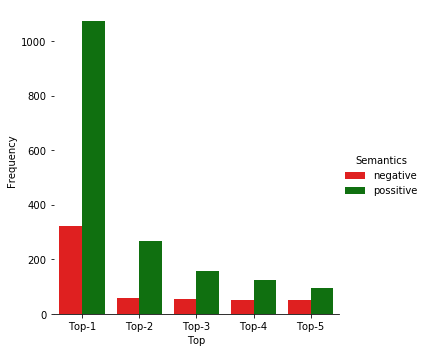

In [21]:
raw_data = {'Top':['Top-1', 'Top-2', 'Top-3', 'Top-4', 'Top-5']*2,
           'Semantics':['negative']*5 + ['possitive']*5,
           'Frequency':list(map(lambda x: freq_in_twits[x], negative_list)) + list(map(lambda x: freq_in_twits[x], possitive_list)),
           'Word':negative_list + possitive_list}
df = pd.DataFrame(raw_data, columns=['Semantics','Top','Frequency','Word'])
print(df)
g = sns.catplot(x="Top", y="Frequency", hue="Semantics", data=df,
                height=5, kind="bar", palette={'possitive':'g', 'negative':'r'})
g.despine(left=True)
g.set_ylabels("Frequency")

6. Оценить распределение положительных/отрицательных/нейтральных твитов по времени.

In [65]:
outset = set(sentence_list)
delta = timedelta(minutes = 30)
mintime = sentence_list[0].time
for sentence in sentence_list:
    mintime = min(mintime, sentence.time)
time = mintime + delta
delta = timedelta(minutes = 10)

time_list = [time]
possitive_time = [0]
neutral_time = [0]
negative_time = [0]
sum_time = [0]

for sentence in sorted(sentence_list, key= lambda x: x.time):
    if sentence.time >= time:
        time += delta
        possitive_time.append(possitive_time[-1])
        neutral_time.append(neutral_time[-1])
        negative_time.append(negative_time[-1])
        sum_time.append(sum_time[-1])
        time_list.append(time)
    sum_time[-1] += 1
    if sentence.estimation > 0:
        possitive_time[-1] += 1
    elif sentence.estimation == 0:
        neutral_time[-1] += 1
    else:
        negative_time[-1] += 1
print(sum_time[-1] == total_twits)
with open('hours.txt','w', encoding='UTF8') as file:
    for possitive, neutral, negative, time, sumt in zip(possitive_time, neutral_time, negative_time, time_list, sum_time):
        print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits), file= file)
        #print('%s - %s : %d : %.5f / %.5f / %.5f' % (mintime, time, sumt, possitive/total_twits, neutral/total_twits, negative/total_twits))

True


367


<StemContainer object of 3 artists>

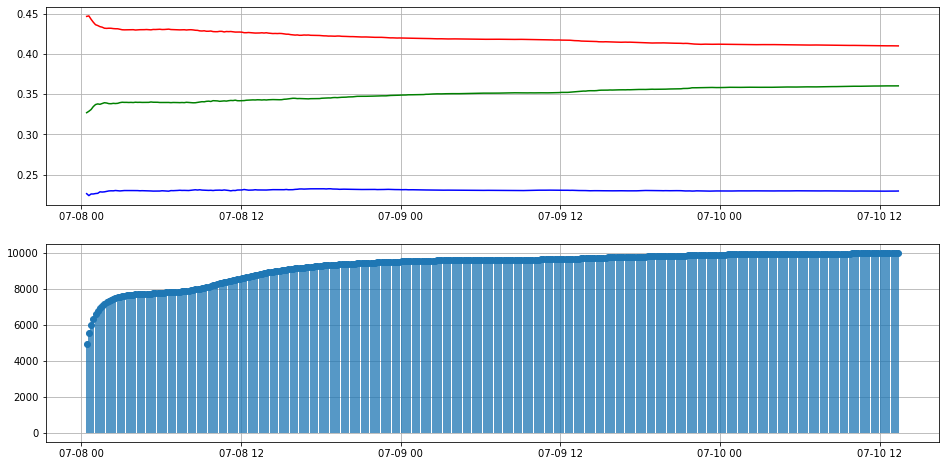

In [82]:
possitive_ax = [x/s for x, s in zip(possitive_time, sum_time)]
neutral_ax = [x/s for x, s in zip(neutral_time, sum_time)]
negative_ax = [x/s for x, s in zip(negative_time, sum_time)]
print(len(time_list))

fig, (ax1, ax3) = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 8))


ax1.grid(True)
#ax2.grid(True)
ax3.grid(True)

ax1.plot(time_list, possitive_ax, 'r', time_list, neutral_ax, 'g', time_list, negative_ax, 'b', linestyle='solid')
ax3.stem(time_list, sum_time, label="Number of tweets", basefmt="None", use_line_collection=True)

7*. ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ. Определение точности эмпирической оценки твитов.

In [83]:
empirical_estimation = {}
accuracy = 0

for word in freq_in_twits:
    empirical_estimation[word] = 0

for sentence in sentence_list:
    for word in sentence.used_words:
        empirical_estimation[word] += sentence.estimation

for word in freq_in_twits:
    empirical_estimation[word] /= count_words[word]

deviation = {}

for word in freq_in_twits:
    deviation[word] = abs(word_estimations[word] - empirical_estimation[word])
    if deviation[word] <= 1 or (word_estimations[word] > 0 and empirical_estimation[word] > 0) or (word_estimations[word] < 0 and empirical_estimation[word] < 0):
        accuracy += 1

#deviation_list = sorted(deviation.items(), key= lambda x: x[1], reverse=False)
deviation_list = sorted(deviation, key= lambda x: deviation[x], reverse=False)

with open('estimation_check.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Closest:", file= file)
    for word in deviation_list[:5]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation[word]), file= file)
    print(file= file)
    
    print("Top-5 Furthest:", file= file)
    for word in deviation_list[-1:-6:-1]:
        print("%s   %.2f   %.2f" % (word, word_estimations[word], empirical_estimation[word]), file= file)
    print(file= file)
    
    print("Estimation accuracy: %.3f%%" % (100*accuracy/len(freq_in_twits)), file=file)
    
with open('estimation_check.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Closest:

удаться   0.00   0.00

хобби   0.00   0.00

домогаться   0.00   0.00

заесть   0.00   0.00

послушать   0.00   0.00



Top-5 Furthest:

блятьблять   0.00   -42.00

унизить   0.00   -13.00

бучий   0.00   -13.00

хуемраааааазить   0.00   -11.00

еврей   0.00   -11.00



Estimation accuracy: 75.157%



8*. ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ. Определить слова с самой положительной и отрицательной окраской.

In [84]:
empirical_estimation_list = sorted(empirical_estimation.items(), key= lambda x: x[1])

with open('best_worst.txt', 'w', encoding='UTF8') as file:
    print("Top-5 Most Negative:", file= file)
    for word, estimation in empirical_estimation_list[:5]:
        print(word, estimation, file= file)
    print(file= file)
    
    print("Top-5 Most Positive:", file= file)
    for word, estimation in empirical_estimation_list[-1:-6:-1]:
        print(word, estimation, file= file)

with open('best_worst.txt', encoding='UTF8') as file:
    for line in file:
        print(line)

Top-5 Most Negative:

блятьблять -42.0

бучий -13.0

унизить -13.0

хуйнуть -11.0

отмудохать -11.0



Top-5 Most Positive:

силач 9.0

кромь 9.0

горесть 8.0

послание 7.0

дарита 7.0

